**Human Emotions Recognition using Deep Learning**

In [2]:
!pip install tensorflow==2.15.0
!pip install wordcloud
!pip install nltk

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importing Deep learning Packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text  import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Importing Machine Learning Packages

from sklearn.preprocessing import LabelEncoder
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
from wordcloud import WordCloud


In [4]:
data=pd.read_csv("train.csv",header=None,sep=";", names = ["Comment","Emotions"])

In [5]:
data.head()

,Comment,Emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
data.shape

(16000, 2)

In [7]:
data["length"] = [len(x) for x in data["Comment"]]

In [8]:
data.head()

,Comment,Emotions,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [9]:
data.isnull().sum()

Comment     0
Emotions    0
length      0
dtype: int64

In [10]:
data.duplicated().sum()

1

In [11]:
data.drop_duplicates(inplace=True)

In [12]:
data.shape

(15999, 3)

##EDA

In [13]:
data["Emotions"].value_counts()   # we have imbalanced data

joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotions, dtype: int64

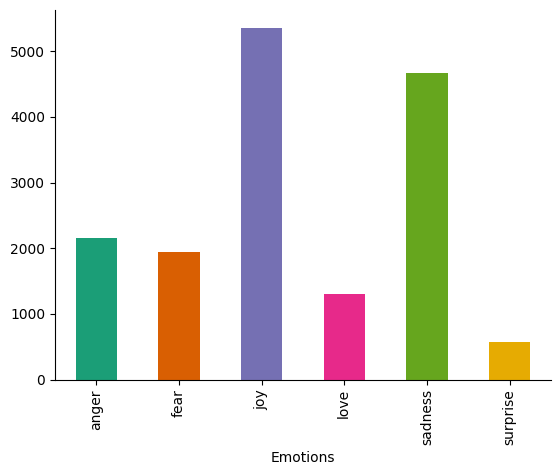

In [14]:
data.groupby('Emotions').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

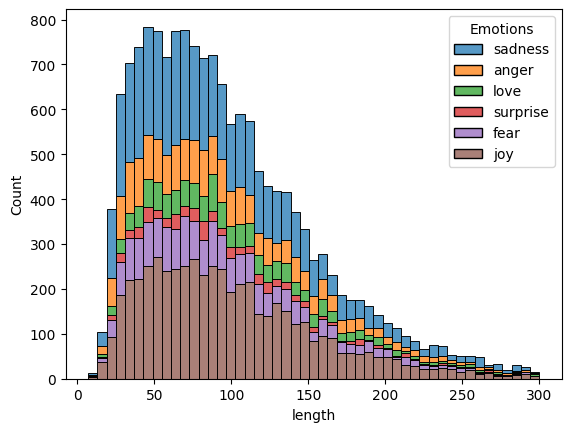

In [15]:
#Distribution of data
sns.histplot(data=data, x="length", multiple = "stack",hue="Emotions")
plt.show()

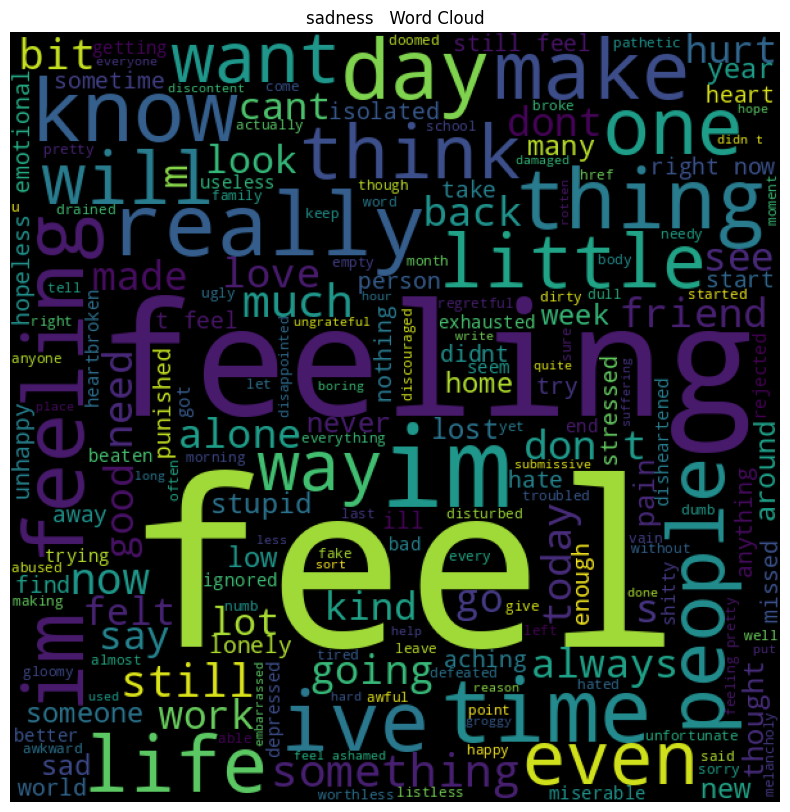

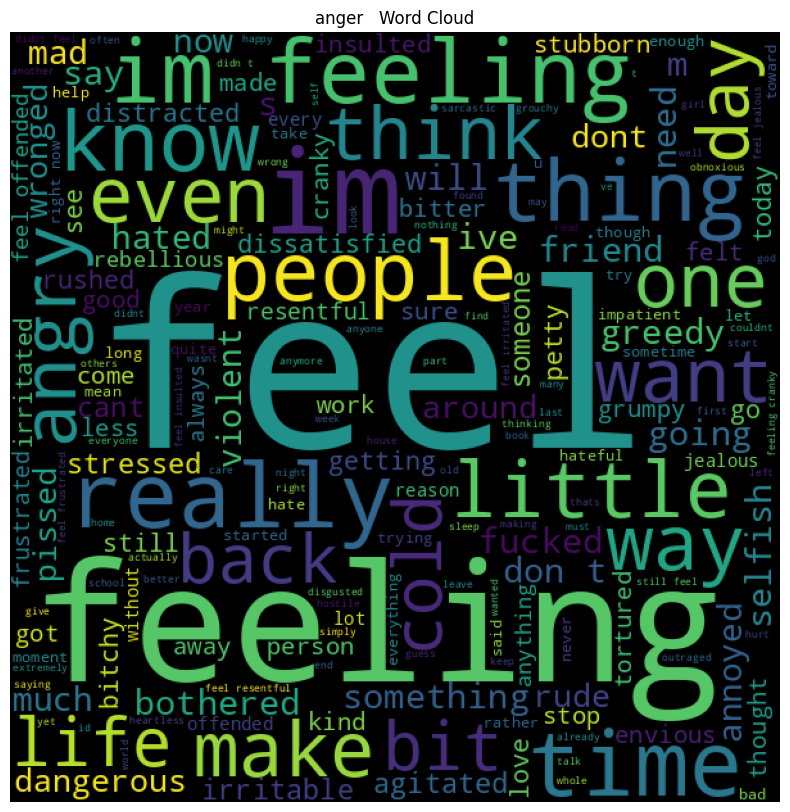

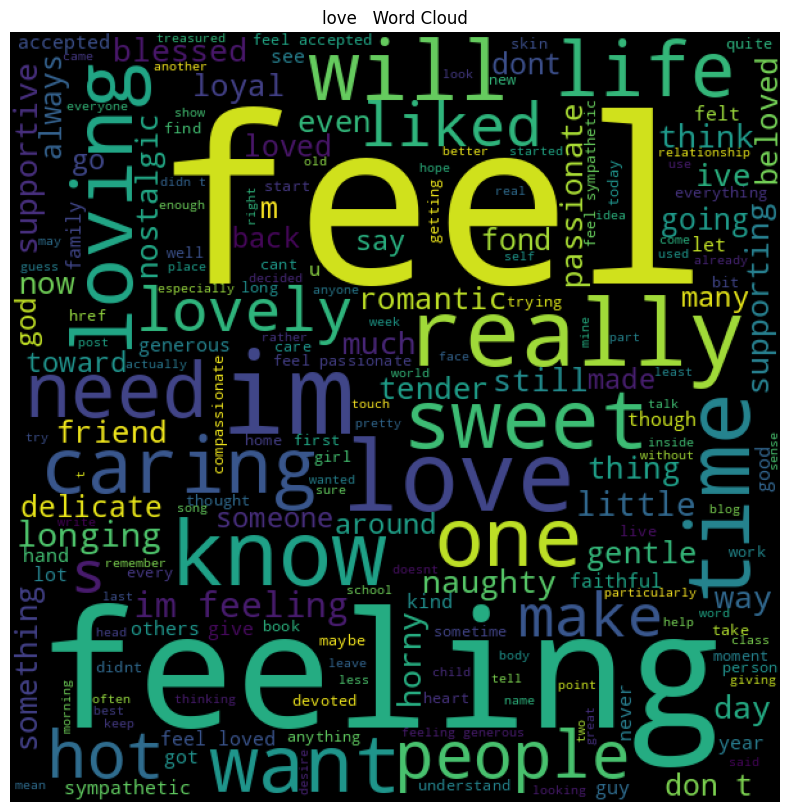

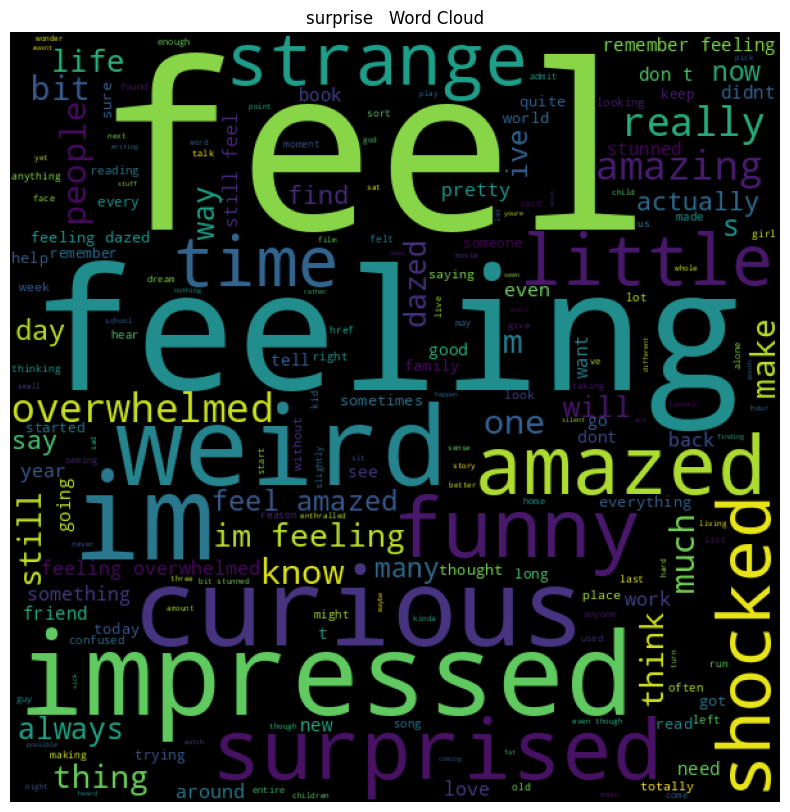

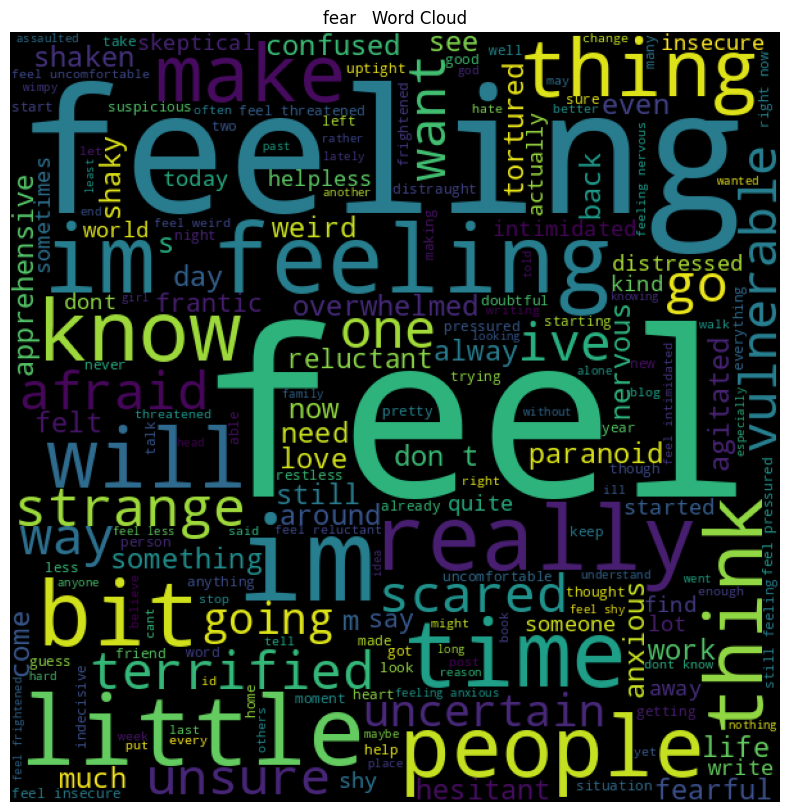

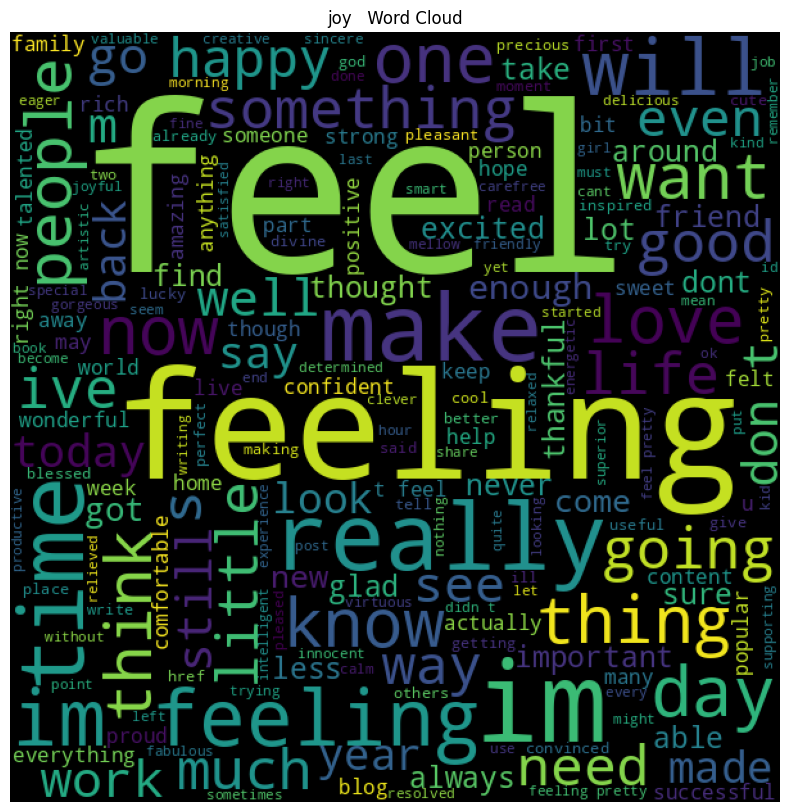

In [16]:
# Creating word cloud for Emotions
def word_cloud(WordCloud,emotion):
  plt.figure(figsize=(10,10))
  plt.title(emotion+ "   Word Cloud")
  plt.imshow(wordcloud)
  plt.axis("off")

Emotions_list=data["Emotions"].unique()
for emotion in Emotions_list:
  text =" ".join([sentence for sentence in data.loc[data["Emotions"]==emotion,"Comment"]])
  wordcloud=WordCloud(width=600, height=600).generate(text)
  word_cloud(wordcloud,emotion)


## Data Pre-Processing

In [17]:
lb=LabelEncoder()
data["Emotions_Encoded"]=lb.fit_transform(data["Emotions"])
data.head()

,Comment,Emotions,length,Emotions_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0


## Model Building

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# importing all the model for multiclass classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

In [19]:
df=data.copy()

In [20]:
nltk.download('stopwords')
stopwords=set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
def clean_text(text):
  stemmer = PorterStemmer()
  # to remove all the numbers special characters except the small and capital case words.
  text = re.sub("[^a-zA-Z]"," ",text)
  # converting upper case to Lower case
  text = text.lower()
  # splitting the sentences into words
  text = text.split()
  # stemming anf removing the stop words.
  text = [stemmer.stem(word) for word in text if word not in stopwords]
  # again joining the single words into sentences
  return " ".join(text)

In [22]:
# Applying the function to the comments and creating new column called cleaned_comment
df["Cleaned_comment"]=df["Comment"].apply(clean_text)

In [23]:
df.head()

,Comment,Emotions,length,Emotions_Encoded,Cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi


In [24]:
X_train,X_test,y_train,y_test=train_test_split(df["Cleaned_comment"],df["Emotions_Encoded"],test_size=0.20,random_state=20)

In [25]:
X_train.head()

10869    use envis would work long thick lash strong fe...
15211                      choos feel terrif href http www
9120                                feel think dumb rather
10940                                       feel sorri guy
14524    feel like time come fearless rescu everyon mad...
Name: Cleaned_comment, dtype: object

In [26]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [27]:
classifier = {
    "Multinomial Navive Baise" : MultinomialNB(),
    "Logistic Regression" : LogisticRegression(),
    "Random Forest" : RandomForestClassifier(),
    "Support Vector Machine" : SVC()
}

for name,clf in classifier.items():
  print(f"\n-------------{name}----------")
  clf.fit(X_train_tfidf,y_train)
  y_pred_tfidf=clf.predict(X_test_tfidf)
  accuracy_tfidf = accuracy_score(y_test,y_pred_tfidf)
  print(f"\nAccuracy using TF-IDF: {accuracy_tfidf*100}")
  print("Classification report: ")
  print(classification_report(y_test,y_pred_tfidf))



-------------Multinomial Navive Baise----------

Accuracy using TF-IDF: 68.03125
Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.33      0.49       419
           1       0.89      0.29      0.44       351
           2       0.62      0.96      0.76      1104
           3       1.00      0.08      0.14       272
           4       0.70      0.91      0.79       946
           5       0.00      0.00      0.00       108

    accuracy                           0.68      3200
   macro avg       0.69      0.43      0.44      3200
weighted avg       0.73      0.68      0.62      3200


-------------Logistic Regression----------

Accuracy using TF-IDF: 83.96875
Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       419
           1       0.84      0.74      0.79       351
           2       0.82      0.94      0.87      1104
           3       0.83      0.56

## Selecting the model

In [28]:
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_pred_rf=rf.predict(X_test_tfidf)



In [29]:
# defining a function for predicting emotions
def prediction(input_text):
  # Cleaning the input text
  cleaned_text = clean_text(input_text)

  # Vectorizing the input usign TFIDF
  input_vectorized = tfidf_vectorizer.transform([cleaned_text])

  # making prediction using Random Forest Classifier
  predicted_Code = rf.predict(input_vectorized)[0]  # it will give number code of the emotion

  # getting named emotion corresponding to number code of emotion
  predicted_emotion = lb.inverse_transform([predicted_Code])[0]
  label=np.max(rf.predict(input_vectorized)[0])
  return predicted_emotion,label

In [30]:
# Test-1
inputs = ["I dont like your presentation",
         "I am feeling good",
         "This is outrageous,how can you talk like that",
         "i am feeling grouchy",
          "I am sorry about this" ,
          "she is really sweet and caring"
]

for input in inputs:
  print(input)
  predict_emotion,label = prediction(input)
  print("predicted emotion: ",predict_emotion)
  print("Predicted Label : ",label)
  print("-----------------------------------")

I dont like your presentation
predicted emotion:  anger
Predicted Label :  0
-----------------------------------
I am feeling good
predicted emotion:  joy
Predicted Label :  2
-----------------------------------
This is outrageous,how can you talk like that
predicted emotion:  anger
Predicted Label :  0
-----------------------------------
i am feeling grouchy
predicted emotion:  anger
Predicted Label :  0
-----------------------------------
I am sorry about this
predicted emotion:  sadness
Predicted Label :  4
-----------------------------------
she is really sweet and caring
predicted emotion:  love
Predicted Label :  3
-----------------------------------


In [31]:
# saving the files
import pickle
pickle.dump(rf,open("RandomForestClassifier.pkl","wb"))
pickle.dump(lb,open("LabelEncoder.pkl","wb"))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl","wb"))

In [32]:
import sklearn
print(sklearn.__version__)

1.2.2


##Applying Deep Learning Using LSTM


Text Cleaning

In [33]:
max_length=max([len(w) for w in data["Comment"]])
max_length

300

In [34]:
min_length=min([len(w) for w in data["Comment"]])
min_length

7

In [35]:
def clean_text(df,column,vocab_size,max_len):
  stemmer = PorterStemmer()

  corpus = []
  for text in df[column]:
    text = re.sub("[^a-zA-Z]",' ' ,text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(w) for w in text if w not in stopwords]
    text = " ".join(text)
    corpus.append(text)


  # converting text to vector
  one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
  # padding the one hot word as the maximum lenth of one comment is 300 words
  pad = pad_sequences(sequences=one_hot_word, maxlen=max_length, padding= "pre")
  return pad

X_train = clean_text(data,"Comment",vocab_size=11000,max_len=300)



In [36]:
data.head()

,Comment,Emotions,length,Emotions_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0


In [37]:
X_train


array([[   0,    0,    0, ..., 4835, 3334, 1414],
       [   0,    0,    0, ..., 2739, 5999, 2872],
       [   0,    0,    0, ..., 3334, 2028,   63],
       ...,
       [   0,    0,    0, ..., 7508, 8539, 9904],
       [   0,    0,    0, ..., 3765, 7567, 3812],
       [   0,    0,    0, ..., 3334, 2532, 7683]], dtype=int32)

In [38]:
#Converting the Emotions_Encoded to categorical vectors also
y_train = to_categorical(data["Emotions_Encoded"])

In [39]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

## Model Building

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
# to avoid overfitting we use dropout function
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation="sigmoid"))  # for hidden layer we use sigmoid
model.add(Dropout(0.2))
model.add(Dense(6, activation="softmax"))   # for multiclass we use softmax activation function in output layer

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

# training the model
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)


Epoch 1/5
250/250 [==============================] - 225s 889ms/step - loss: 1.6158 - accuracy: 0.3306
Epoch 2/5
250/250 [==============================] - 221s 881ms/step - loss: 0.9658 - accuracy: 0.6798
Epoch 3/5
250/250 [==============================] - 221s 883ms/step - loss: 0.4220 - accuracy: 0.8654
Epoch 4/5
250/250 [==============================] - 227s 907ms/step - loss: 0.2664 - accuracy: 0.9136
Epoch 5/5
 13/250 [>.............................] - ETA: 3:23 - loss: 0.1744 - accuracy: 0.9495

##Predictive System

In [42]:
def pred(text):
    stemmer = PorterStemmer()

    corpus = []
    text = re.sub("[^a-zA-Z]",' ' ,text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(w) for w in text if w not in stopwords]
    text = " ".join(text)
    corpus.append(text)


  # converting text to vector
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
  # padding the one hot word as the maximum lenth of one comment is 300 words
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding= "pre")
    return pad





sentences=["I hate mangoes",
           "I feel strong and happy",
           "She is really sweet and caring"
           ]

for sent in sentences:
  clean_sent = pred(sent)
  emotion = lb.inverse_transform(np.argmax(model.predict(clean_sent), axis=-1))[0]
  label= np.max(model.predict(clean_sent))
  print(emotion)
  print(label)
  print("-----------------------------")


1/1 [==============================] - 0s 113ms/step
anger
0.6574323
-----------------------------
1/1 [==============================] - 0s 147ms/step
joy
0.99492574
-----------------------------
1/1 [==============================] - 0s 68ms/step
love
0.49804258
-----------------------------


#Save the model


In [43]:
model.save("model.h5")